In [1]:
%matplotlib inline

In [17]:
import numpy as np
import random
import pandas as pd
import itertools
from graph_tool import Graph, GraphView
from graph_tool.draw import graph_draw
from tqdm import tqdm

from matplotlib import pyplot as plt

from viz_helpers import lattice_node_pos, InfectionProbability
from minimum_steiner_tree import min_steiner_tree
from cascade_generator import si, observe_cascade
from eval_helpers import infection_precision_recall, top_k_infection_precision_recall
from graph_helpers import remove_filters, load_graph_by_name, gen_random_spanning_tree

from inference import infer_infected_nodes, infection_probability
from experiment import gen_input

In [70]:
graph_name = 'dolphin'
g = load_graph_by_name(graph_name)

if graph_name == 'lattice':
    pos = lattice_node_pos(g, (10, 10))

In [71]:
n_rounds = 100
n_samples = 200
subset_size = 50
if graph_name == 'lattice':
    stop_fraction = 0.25
    obs_fraction = 0.25
    ks = np.arange(1, 30, 2)
elif graph_name == 'karate':
    stop_fraction = 0.5
    obs_fraction = 0.25
    ks = np.arange(1, 18, 2)
elif graph_name == 'dolphin':
    stop_fraction = 0.5
    obs_fraction = 0.25
    ks = np.arange(1, 30, 2)
    

In [55]:
sp_trees = [gen_random_spanning_tree(g) for _ in range(n_samples)]

In [78]:
from joblib import Parallel, delayed

def one_batch_for_method_par(n_rounds, inference_kwargs, ks=[5, 10, 15, 20]):
    scores = {k: [] for k in ks}
    def one_run():
        obs, c = gen_input(g, stop_fraction=stop_fraction, q=obs_fraction, p=1)
        probas = infection_probability(g, obs, **inference_kwargs)
        return [(k, top_k_infection_precision_recall(probas, c, obs, k=k)) for k in ks]
    result = Parallel(n_jobs=-1)(one_run() for _ in tqdm(range(n_rounds), total=n_rounds))
    for row in result:
        for k, sc in row:
            scores[k].append(sc)
    return scores

In [66]:
def one_batch_for_method(n_rounds, inference_kwargs, ks=[5, 10, 15, 20]):
    scores = {k: [] for k in ks}
    for i in tqdm(range(n_rounds)):
        obs, c = gen_input(g, stop_fraction=stop_fraction, q=obs_fraction, p=1)
        probas = infection_probability(g, obs, **inference_kwargs)
        for k in ks:
            prec, rec = top_k_infection_precision_recall(probas, c, obs, k=k)
            scores[k].append((prec, rec))
    return scores

In [72]:
sampling_scores = one_batch_for_method(
    n_rounds, inference_kwargs={'method': 'sampling', 'sp_trees': sp_trees},
    ks=ks)

100%|██████████| 100/100 [01:28<00:00,  1.04it/s]


In [73]:
subset_scores = one_batch_for_method(
    n_rounds, inference_kwargs={'method': 'sampling', 'sp_trees': sp_trees, 'subset_size': subset_size},
    ks=ks)

100%|██████████| 100/100 [01:20<00:00,  1.24it/s]


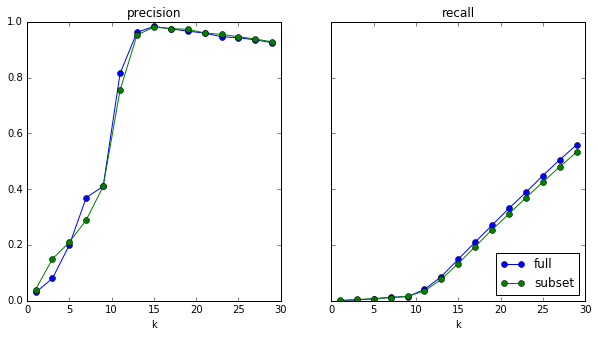

In [74]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)

for scores in [sampling_scores, subset_scores]:
    # for each method
    mean_scores = np.asarray([np.mean(scores[k], axis=0)
                              for k in ks])
    # precision
    ax[0].plot(ks, mean_scores[:, 0], '-o')
    
    # recall
    ax[1].plot(ks, mean_scores[:, 1], '-o')
ax[0].set_xlabel('k')
ax[1].set_xlabel('k')

ax[0].set_title('precision')
ax[1].set_title('recall')
plt.legend(['full', 'subset'], loc='lower right')
fig.savefig('figs/inference_method_comparison_{}.pdf'.format(graph_name))